Group members : 
1.   **Prabhudev Bengaluru Kumar - pbenga2s**
2.   **Kaushik Manjunatha - kmanju2s**

Project : Chatbot

The aim of this project work is to provide a dialogue generation chatbot.

Dataset link : https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

**Packages**

In [ ]:
import numpy as np 
import os
import tensorflow as tf
tf.random.set_seed(1234)
import tensorflow_datasets as tfds
import re
import matplotlib.pyplot as plt

In [ ]:
for directory_name, _, file_names in os.walk('/content/drive/My Drive/NLP/cornell movie-dialogs corpus'):
    for file in file_names:
        print(os.path.join(directory_name, file))

/content/drive/My Drive/NLP/cornell movie-dialogs corpus/movie_conversations.txt
/content/drive/My Drive/NLP/cornell movie-dialogs corpus/movie_characters_metadata.txt
/content/drive/My Drive/NLP/cornell movie-dialogs corpus/.DS_Store
/content/drive/My Drive/NLP/cornell movie-dialogs corpus/chameleons.pdf
/content/drive/My Drive/NLP/cornell movie-dialogs corpus/movie_lines.txt
/content/drive/My Drive/NLP/cornell movie-dialogs corpus/raw_script_urls.txt
/content/drive/My Drive/NLP/cornell movie-dialogs corpus/movie_titles_metadata.txt
/content/drive/My Drive/NLP/cornell movie-dialogs corpus/README.txt
/content/drive/My Drive/NLP/cornell movie-dialogs corpus/formatted_movie_lines.txt


**Preprocess data**

In [ ]:
def preprocess_data(data):
    data = data.lower().strip()
    data = re.sub(r"([?.!,])", r" \1 ", data)
    data = re.sub(r'[" "]+', " ", data)
    data = re.sub(r"[^a-zA-Z?.,!]+", " ", data)
    data = data.strip()
    return data

In [ ]:
def convert_and_load_movie_conversations():
    sentence_format = {}
    with open('/content/drive/My Drive/NLP/cornell movie-dialogs corpus/movie_lines.txt', encoding = 'utf-8', errors = 'ignore') as file_name:
        lines = file_name.readlines()
    for line in lines:
        position = line.replace('\n', '').split(' +++$+++ ')
        sentence_format[position[0]] = position[4]
    generated_questions = []
    generated_answers = []
    with open('/content/drive/My Drive/NLP/cornell movie-dialogs corpus/movie_conversations.txt', encoding = 'utf-8', errors = 'ignore') as file_name:
        lines = file_name.readlines()
    for line in lines:
        position = line.replace('\n', '').split(' +++$+++ ')
        sentence = [line[1:-1] for line in position[3][1:-1].split(', ')]
        for i in range(len(sentence) - 1):
            generated_questions.append(preprocess_data(sentence_format[sentence[i]]))
            generated_answers.append(preprocess_data(sentence_format[sentence[i + 1]]))
            if len(generated_questions) >= 10000:
                return generated_questions, generated_answers
    return generated_questions, generated_answers


converted_questions, converted_answers = convert_and_load_movie_conversations()
print(len(converted_questions))

10000


**Examples of questions and answers formed to train the model**

In [ ]:
# This question and answer is converted from the movie conversation  of line L198 and L199
print('Example of converted question: ',converted_questions[3])
print('Example of converted answer: ',converted_answers[3])

Example of converted question:  you re asking me out . that s so cute . what s your name again ?
Example of converted answer:  forget it .


In [ ]:
# This question and answer is converted from the movie conversation  of line L365 and L366
print('Example of converted question: ',converted_questions[17])
print('Example of converted answer: ',converted_answers[17])

Example of converted question:  you have my word . as a gentleman
Example of converted answer:  you re sweet .


In [ ]:
# This question and answer is converted from the movie conversation  of line L367 and L368
print('Example of converted question: ',converted_questions[18])
print('Example of converted answer: ',converted_answers[18])

Example of converted question:  how do you get your hair to look like that ?
Example of converted answer:  eber s deep conditioner every two days . and i never , ever use a blowdryer without the diffuser attachment .


In [ ]:
# This question and answer is converted from the movie conversation  of line L70 and L71
print('Example of converted question: ',converted_questions[138])
print('Example of converted answer: ',converted_answers[138])

Example of converted question:  how many people were in your old school ?
Example of converted answer:  thirty two .


In [ ]:
# This question and answer is converted from the movie conversation  of line L66078 and L66079
print('Example of converted question: ',converted_questions[9999])
print('Example of converted answer: ',converted_answers[9999])

Example of converted question:  you re the tom hardy i ve been reading about in the papers , right ? new orleans pd fired you for taking bribes from guissepe torres .
Example of converted answer:  it was for suspicion of bribery , it s really all in the wording


**Tokenizing the QnA**

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(converted_questions + converted_answers, target_vocab_size = 2**13)
start_sent, end_sent = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
voc_size = tokenizer.vocab_size + 2

In [ ]:
# Maximum sentence length is taken as 30
def preprocess_and_tokenize_QnA(questions, answers):
    formed_questions = []
    formed_answers = []
    for (question_samp, answer_samp) in zip(questions, answers):
        question_samp = start_sent + tokenizer.encode(question_samp) + end_sent
        answer_samp = start_sent + tokenizer.encode(answer_samp) + end_sent
        if len(question_samp) <= 30 and len(answer_samp) <= 30:
            formed_questions.append(question_samp)
            formed_answers.append(answer_samp)
    formed_questions = tf.keras.preprocessing.sequence.pad_sequences(formed_questions, maxlen = 30, padding = 'post')
    formed_answers = tf.keras.preprocessing.sequence.pad_sequences(formed_answers, maxlen=30, padding = 'post')
    return formed_questions, formed_answers
formed_questions, formed_answers = preprocess_and_tokenize_QnA(converted_questions, converted_answers)


In [ ]:
print('Vocab size: {}'.format(voc_size))
print('Number of samples: {}'.format(len(formed_questions)))

Vocab size: 7749
Number of samples: 7887


**Multi-Head Attention**

In [ ]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(({'inputs':formed_questions, 'dec_inputs':formed_answers[:, :-1]},{'outputs':formed_answers[:, 1:]}))
dataset = dataset.cache()
dataset = dataset.shuffle(20000)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
def cal_attention_wgts(query, key, value, mask):
    prd = tf.matmul(query, key, transpose_b = True)
    cast_tpy = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = prd / tf.math.sqrt(cast_tpy)
    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)
    #sofmax is normalized on the last axis (seq_len_k)
    wgts = tf.nn.softmax(logits, axis = -1)
    attn_wgts = tf.matmul(wgts, value)
    return attn_wgts

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model
    assert d_model % self.num_heads == 0
    self.depth = d_model // self.num_heads
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)
    self.dense = tf.keras.layers.Dense(units=d_model)
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])
  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)
    scaled_attention = cal_attention_wgts(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))
    outputs = self.dense(concat_attention)
    return outputs

In [ ]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1- tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000,(2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(position = tf.range(position, dtype=tf.float32)[:, tf.newaxis], i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], d_model = d_model)
        sines = tf.math.sin(angle_rads[:, 1::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis = -1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32) 
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
        sample_pos_encoding = PositionalEncoding(50, 512)
sample_pos_encoding = PositionalEncoding(50, 512)


Encoder

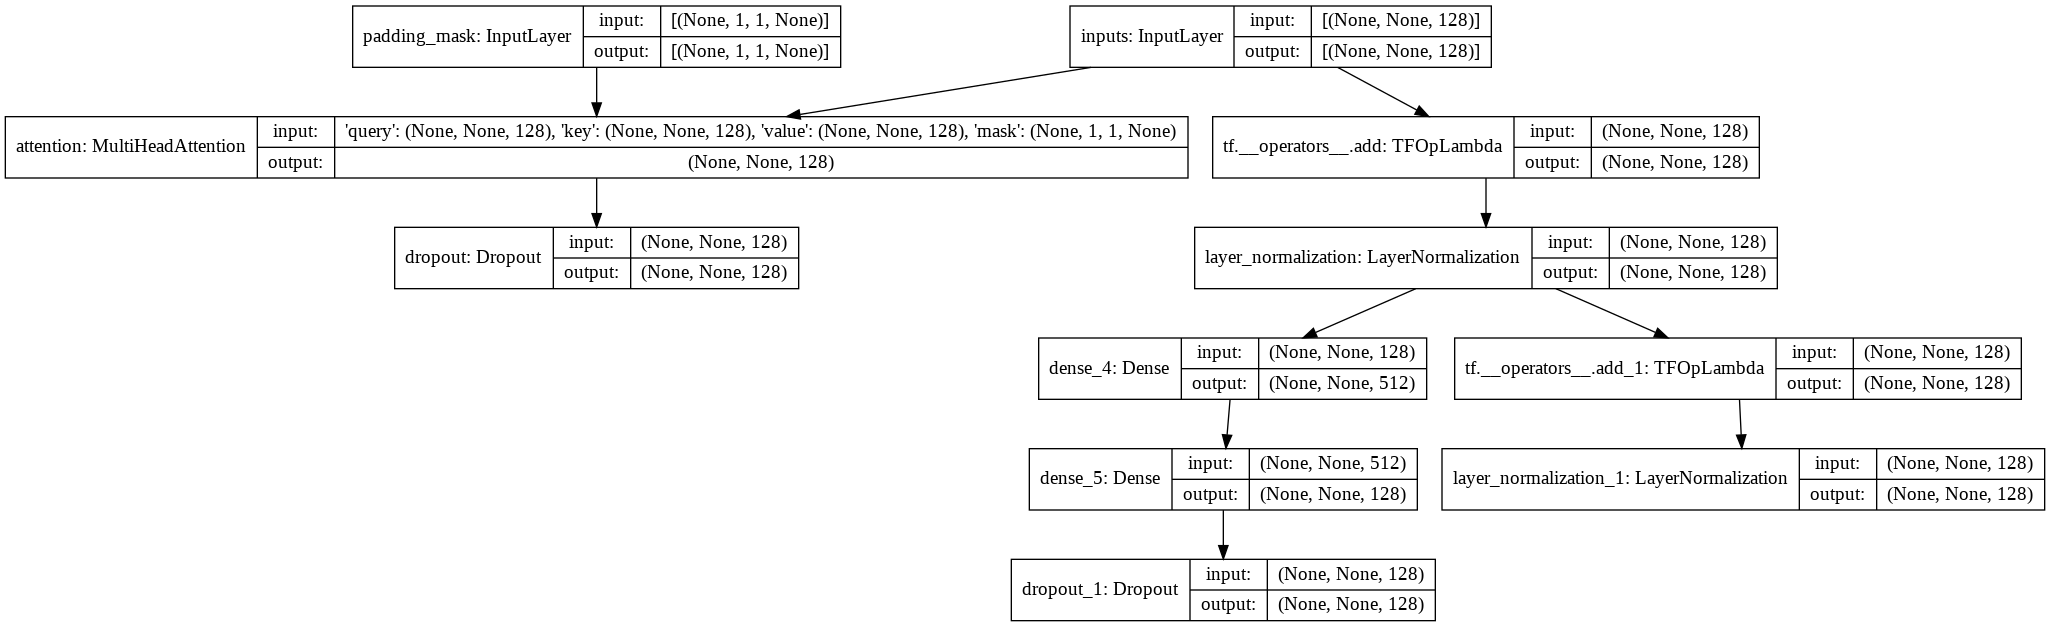

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
sample_encoder_layer = encoder_layer(
                                     units = 512,
                                     d_model = 128,
                                     num_heads = 4,
                                     dropout = 0.3,
                                     name = "encoder_layer")
tf.keras.utils.plot_model(sample_encoder_layer, to_file = 'encoder_layer.png', show_shapes = True)

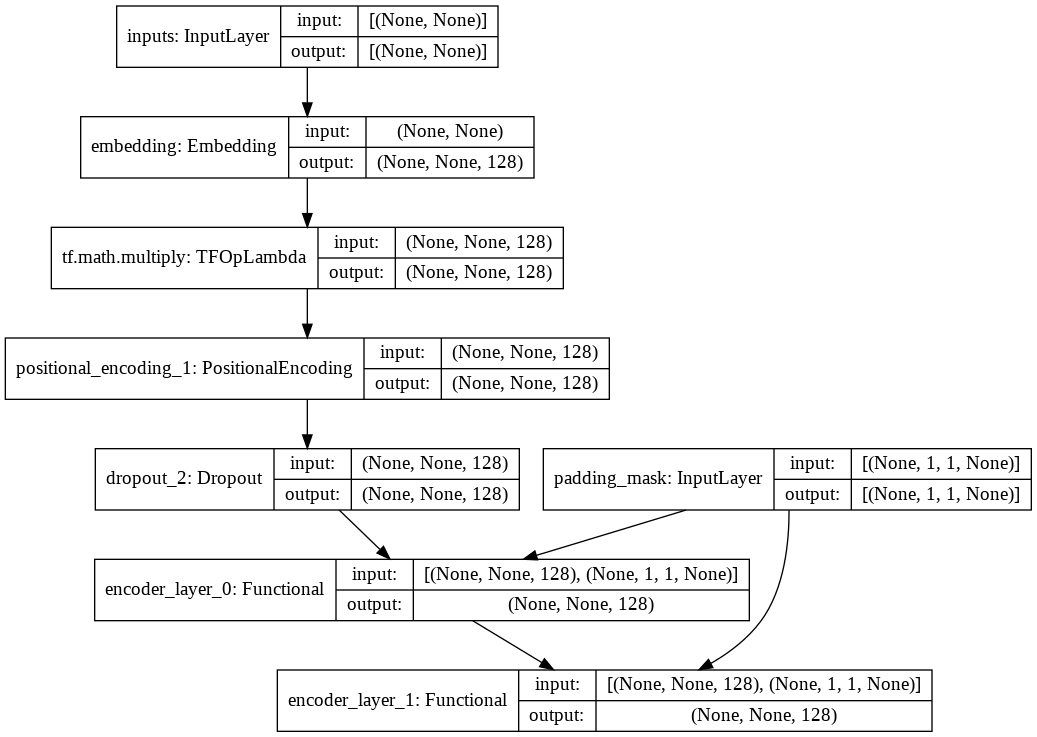

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])


  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
sample_encoder = encoder(vocab_size = 8192, 
                         num_layers = 2,
                         units = 512,
                         d_model = 128,
                         num_heads = 4, 
                         dropout = 0.3,
                         name = "sample_encounter")

tf.keras.utils.plot_model(sample_encoder, to_file='encoder.png', show_shapes = True)

**Decoder**

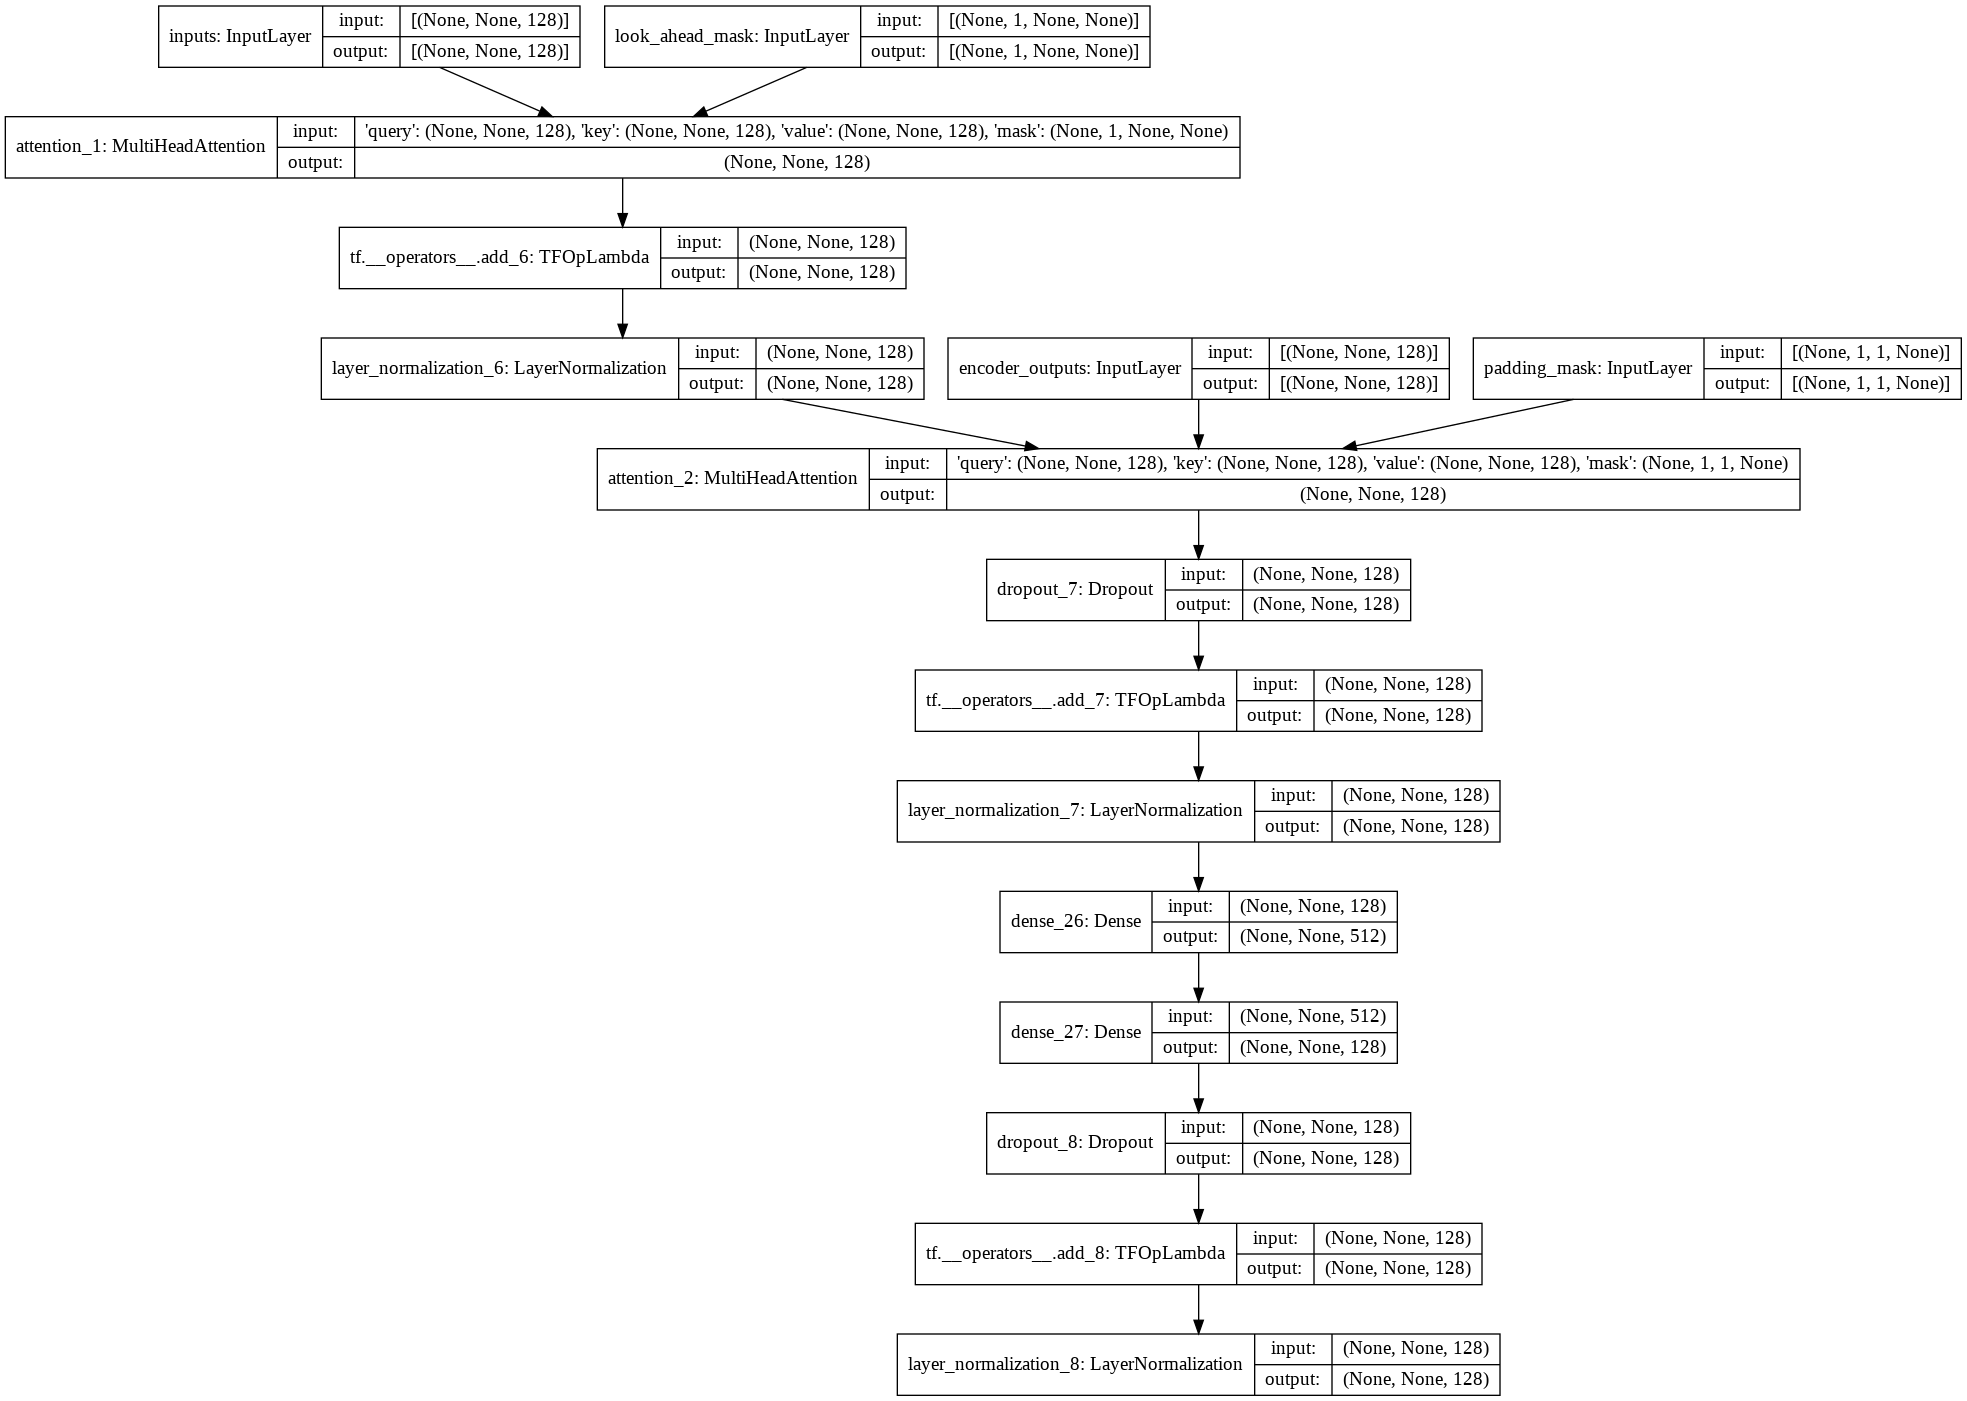

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name = "decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name = 'inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name = "look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name = "padding_mask")
    
    attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(inputs={'query':inputs,
                                                                                    'key': inputs, 
                                                                                    'value': inputs,
                                                                                    'mask':look_ahead_mask})
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)
    
    attention2 = MultiHeadAttention(d_model, num_heads, name = "attention_2")(inputs={'query':attention1,
                                                                                      'key':enc_outputs,
                                                                                      'value':enc_outputs,
                                                                                      'mask':padding_mask})
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(attention2 + attention1)
    
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], 
                          outputs = outputs,
                          name = name)
sample_decoder_layer = decoder_layer(units = 512,
                                     d_model = 128,
                                     num_heads = 4,
                                     dropout = 0.3,
                                     name = "sample_decoder_layer")
tf.keras.utils.plot_model(sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

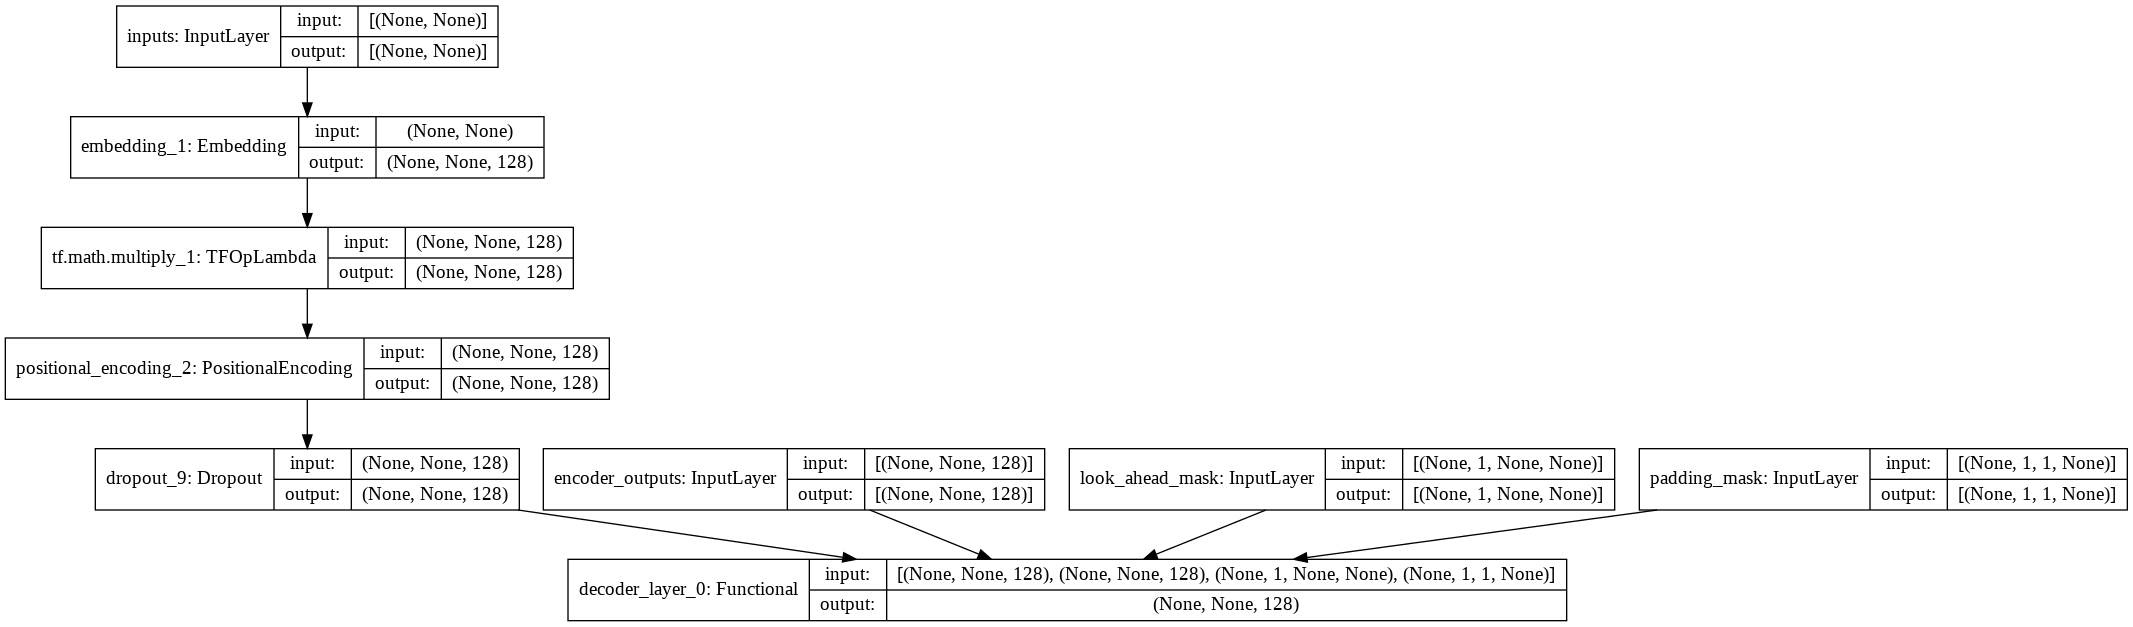

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    
    for i in range(num_layers):
        outputs = decoder_layer(units = units,
                                d_model = d_model,
                                num_heads = num_heads,
                                dropout = dropout,
                                name = 'decoder_layer_{}'.format(i),)(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
        
        return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
                              outputs = outputs,
                              name = name)
sample_decoder = decoder(vocab_size=8192,
                         num_layers=2,
                         units = 512,
                         d_model = 128,
                         num_heads = 4,
                         dropout = 0.3,
                         name = "sample_decoder")
tf.keras.utils.plot_model(sample_decoder, to_file='decoder.png', show_shapes = True)

**Transformer**

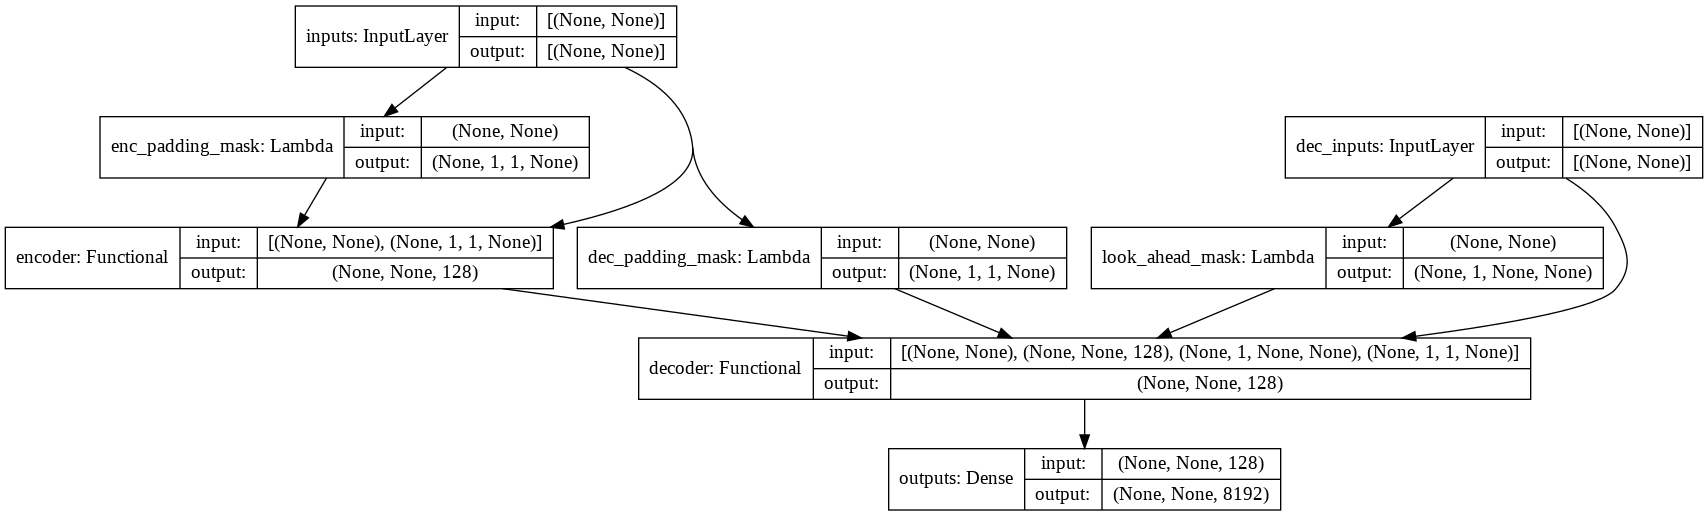

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")
    
    enc_padding_mask = tf.keras.layers.Lambda(
    create_padding_mask, output_shape=(1, 1, None),
    name="enc_padding_mask")(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask,
                                             output_shape=(1, None, None),
                                             name = "look_ahead_mask")(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask,
                                              output_shape=(1, 1, None),
                                              name="dec_padding_mask")(inputs)
    
    enc_outputs = encoder(vocab_size=vocab_size,
                          num_layers= num_layers,
                          units=units,
                          d_model = d_model,
                          num_heads = num_heads,
                          dropout = dropout,)(inputs = [inputs, enc_padding_mask])
    
    dec_outputs = decoder(vocab_size=vocab_size,
                          num_layers=num_layers,
                          units=units,
                          d_model=d_model,
                          num_heads = num_heads,
                          dropout=dropout,)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
sample_transformer = transformer(vocab_size=8192,
                                 num_layers=4,
                                 units=512,
                                 d_model=128,
                                 num_heads = 4,
                                 dropout=0.3,
                                 name="sample_transformer")

tf.keras.utils.plot_model(sample_transformer, to_file="transformer.png", show_shapes=True)

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1
model = transformer(
                    vocab_size = voc_size,
                    num_layers=NUM_LAYERS,
                    units = UNITS,
                    d_model = D_MODEL,
                    num_heads = NUM_HEADS,
                    dropout = DROPOUT)
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, 30 - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits= True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, 30 - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3037952     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

**Training**

In [ ]:
EPOCHS = 20
model.fit(dataset, epochs = EPOCHS)

Epoch 1/20
124/124 [==============================] - 127s 1s/step - loss: 0.6963 - accuracy: 0.2372
Epoch 2/20
124/124 [==============================] - 127s 1s/step - loss: 0.6171 - accuracy: 0.2515
Epoch 3/20
124/124 [==============================] - 128s 1s/step - loss: 0.5359 - accuracy: 0.2680
Epoch 4/20
124/124 [==============================] - 129s 1s/step - loss: 0.4645 - accuracy: 0.2820
Epoch 5/20
124/124 [==============================] - 128s 1s/step - loss: 0.4011 - accuracy: 0.2946
Epoch 6/20
124/124 [==============================] - 128s 1s/step - loss: 0.3494 - accuracy: 0.3048
Epoch 7/20
124/124 [==============================] - 128s 1s/step - loss: 0.3031 - accuracy: 0.3148
Epoch 8/20
124/124 [==============================] - 129s 1s/step - loss: 0.2666 - accuracy: 0.3223
Epoch 9/20
124/124 [==============================] - 128s 1s/step - loss: 0.2419 - accuracy: 0.3276
Epoch 10/20
124/124 [==============================] - 128s 1s/step - loss: 0.2199 - accura

Evaluation

In [ ]:
def evaluate(sentence):
    sentence = preprocess_data(sentence)
    
    sentence = tf.expand_dims(start_sent + tokenizer.encode(sentence) + end_sent, axis = 0)
    
    output = tf.expand_dims(start_sent, 0)
    
    for i in range(30):
        predictions = model(inputs = [sentence, output], training = False)
        
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, end_sent[0]):
            break
            
        # concatenated the predicted_id to the output which is given to the decoder at its input.
        output = tf.concat([output, predicted_id], axis=-1)
        
    return tf.squeeze(output, axis = 0)

def predict(sentence):
    prediction = evaluate(sentence)
    
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    
    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))
    
    return predicted_sentence

**Output chat**

In [ ]:
output = predict('Where have you been?')

Input: Where have you been?
Output: where do you think i ve been ? i took the baby for a stroll in the park .


In [ ]:
output = predict("It's a trap")

Input: It's a trap
Output: it s broke i guess . there s an electric in the bedroom .


In [ ]:
output = predict("How is our little Find the Wench A Date plan progressing?")

Input: How is our little Find the Wench A Date plan progressing?
Output: well , there s a real turd .


In [ ]:
output = predict("What is the time?")

Input: What is the time?
Output: common time .


In [ ]:
output = predict("Two units in four days. How many spares do we have?")

Input: Two units in four days. How many spares do we have?
Output: two more .


In [ ]:
output = predict("What do you mean you know?  He told you he was gonna propose to me?")

Input: What do you mean you know?  He told you he was gonna propose to me?
Output: well , well . . .


In [ ]:
output = predict("Is that woman a complete fruit-loop or is it just me?")

Input: Is that woman a complete fruit-loop or is it just me?
Output: it s just you .


In [ ]:
output = predict("Hey, sweet cheeks.")

Input: Hey, sweet cheeks.
Output: hi , you know .


In [ ]:
output = predict("Did you change your hair?")

Input: Did you change your hair?
Output: no .


In [ ]:
output = predict("I have to be home in twenty minutes.")

Input: I have to be home in twenty minutes.
Output: i don t have to be home til two .


In [ ]:
output = predict("Where did he go?  He was just here.")

Input: Where did he go?  He was just here.
Output: what ?


In [ ]:
output = predict("I counted on you to help my cause. You and that thug are obviously failing. Aren't we ever going on our date?")

Input: I counted on you to help my cause. You and that thug are obviously failing. Aren't we ever going on our date?
Output: yeah . what do you think ?


In [ ]:
output = predict("Have you seen Joey and Kincaid!  God, I can't find them. ")

Input: Have you seen Joey and Kincaid!  God, I can't find them. 
Output: i m sure they re around .


In [ ]:
output = predict("They're coach seats, but the plane lands in Paris. ")

Input: They're coach seats, but the plane lands in Paris. 
Output: i know .


In [ ]:
output = predict("he was this ancient guy I read about who like, killed his kids 'cause they didn't want to run the kingdom the way he thought they should ")

Input: he was this ancient guy I read about who like, killed his kids 'cause they didn't want to run the kingdom the way he thought they should 
Output: they were little one .


In [ ]:
output = predict("what is your name?")

Input: what is your name?
Output: my righteous name is big black .


In [ ]:
output = predict("I get off at eight.")

Input: I get off at eight.
Output: twenty , sire ! how about twenty ? twenty minutes of continuous music . no recitatives .


In [ ]:
output = predict("my husband passed away recently.  Two weeks ago now.")

Input: my husband passed away recently.  Two weeks ago now.
Output: my condolences .


In [ ]:
output = predict("I want you to deal with it.  Immediately")

Input: I want you to deal with it.  Immediately
Output: i m sorry that bug up your ass had to die .


In [ ]:
 output = predict("what've you got on Tuggle's killers?")

Input: what've you got on Tuggle's killers?
Output: jesus , sykes it s been less than ten hours . me and alterez are on it , okay ?


In [ ]:
 output = predict("How you holding up, Wade?")

Input: How you holding up, Wade?
Output: i m fine , fine .


In [ ]:
 output = predict("ur Majesty is there a ballet in figaro")

Input: ur Majesty is there a ballet in figaro
Output: yes , in the third act .


**Reference**

• Attention is all you need: Discovering the Transformer paper - Detailed implementation of a Transformer model in Tensorflow - https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-
paper-73e5ff5e0634

• A. Vaswani, N. Shazeer, N. Parmar, J. Uszkoreit, L. Jones, A. N. Gomez, u. Kaiser, and I. Polosukhin. Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems, NIPS’17, page 6000–6010, Red Hook, NY, USA, 2017. Curran Associates Inc. -
https://dl.acm.org/doi/10.5555/3295222.3295349.

• Transformer model for language understanding -
https://www.tensorflow.org/text/tutorials/transformer#create_the_transformer
https://medium.com/tensorflow/a-transformer-chatbot-tutorial-with-tensorflow-2-0-88bf59e66fe2

• C. Danescu –Niculescu -Mizil and L. Lee. Chameleons in imagined conversations: A new approach to under-standing coordination of linguistic style in dialogs. In Proceedings of the Workshop on Cognitive Modeling and Computational Linguistics, ACL 2011, 2011 -
https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

• Chatbot tutorial using pytorch - https://pytorch.org/tutorials/beginner/chatbot_tutorial.html

• How to build your first chatbot - https://tutorials.botsfloor.com/how-to-build-your-first-chatbot-
c84495d4622d

• Transformers - https://towardsdatascience.com/transformers-141e32e69591

• Deep Learnig for chatbots retrieval based model tensorflowTransformers –
http://www.wildml.com/2016/04/deep-learning-for-chatbots-part-1-introduction/
http://www.wildml.com/2016/07/deep-learning-for-chatbots-2-retrieval-based-model-tensorflow/